In [2]:
import pickle
data = pickle.load(open("data/data.plk", "rb"))

In [3]:
len(data)

4351

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords


wordnet_lemmatizer = WordNetLemmatizer()

In [5]:
def get_lemmatized_words(sentence):
    _temp = []
    tokens = nltk.word_tokenize(sentence)
    lmtzr = WordNetLemmatizer()
    
    for word, token in nltk.pos_tag(tokens):
        if word.strip().lower() not in stopwords.words('english') and word.strip().lower().isalnum():
            _temp.append(lmtzr.lemmatize(word.strip().lower(), get_wordnet_pos(token)))
    return " ".join(_temp)

In [6]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
[[word for word in get_lemmatized_words(x["název (anglicky)"]).split(" ")] for x in data[:2] if len(x["název (anglicky)"]) > 2]

[['salzella', 'declarative', 'language', 'music', 'generation'],
 ['application', 'illustrative', 'explode', 'view', '3d', 'model']]

In [8]:
from gensim import corpora,models, similarities

abstract_list = [[word for word in get_lemmatized_words(x["název (anglicky)"]).split(" ")] for x in data if len(x["název (anglicky)"]) > 2]
print(len (abstract_list))
# corpora.Dictionary(): Dictionary encapsulates the mapping between normalized words and their integer ids.
dictionary = corpora.Dictionary(abstract_list)
print(dictionary)

appear_once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]

# filter_tokens(): Remove the selected bad_ids tokens from all dictionary mappings
dictionary.filter_tokens(appear_once_ids)

# compactify(): Assign new word ids to all words
dictionary.compactify()

print(dictionary)
    

4217
Dictionary(3661 unique tokens: ['', 'strategic', 'aquarium', 'read', 'geolocation']...)
Dictionary(1754 unique tokens: ['', 'strategic', 'read', 'coaster', 'emulation']...)


In [9]:
# doc2bow(): Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples
corpus = [dictionary.doc2bow(words) for words in abstract_list]

#corpora.mmcorpus.MmCorpus.serialize('data/shkspr.mm', corpus)

# TfidfModel(): word-document co-occurrence matrix (integers) into a locally/globally weighted TF_IDF matrix (positive floats)
tfidf = models.TfidfModel(corpus)

In [10]:
papers = [(x["název (anglicky)"], x["katedra"] ) for x in data]
universities = list(set([x["katedra"] for x in data]))

In [11]:
# LsiModel():  Latent Semantic Analysis (aka Latent Semantic Indexing)

lsi = models.lsimodel.LsiModel(corpus=tfidf[corpus], id2word=dictionary,num_topics=len(universities),power_iters=50,onepass=False,chunksize=20)
for i, topic in enumerate(lsi.print_topics(len(universities))):
    print('Topic {}:'.format(i))
    print(topic[1].replace(' + ', "\n"))
    print('')

Topic 0:
0.586*"system"
0.476*"information"
0.289*"management"
0.255*"web"
0.183*"application"
0.159*"project"
0.124*"support"
0.112*"implementation"
0.106*"design"
0.096*"interface"

Topic 1:
0.489*"web"
0.432*"application"
-0.428*"information"
-0.355*"system"
0.197*"interface"
0.126*"user"
0.125*"tool"
0.118*"data"
0.102*"mobile"
0.087*"management"

Topic 2:
0.661*"management"
0.392*"project"
-0.346*"web"
-0.311*"information"
0.252*"software"
0.134*"content"
-0.125*"interface"
0.105*"tool"
-0.102*"service"
-0.084*"portal"

Topic 3:
0.424*"web"
-0.350*"network"
-0.347*"implementation"
-0.283*"data"
0.251*"management"
-0.216*"algorithm"
-0.197*"design"
-0.164*"game"
-0.127*"model"
-0.127*"use"

Topic 4:
0.524*"application"
-0.436*"interface"
-0.368*"user"
-0.230*"implementation"
0.218*"network"
0.199*"mobile"
-0.193*"design"
-0.156*"tool"
0.145*"support"
0.129*"android"

Topic 5:
-0.509*"implementation"
0.469*"network"
-0.246*"application"
0.223*"interface"
-0.204*"design"
-0.198*"algo

In [12]:
papers[:2]

[('Salzella - A Declarative Language for Music Generation', 'K13139'),
 ('Client-server application for illustrative exploded views of 3D models',
  'K13139')]

In [13]:
# Calculate a similarity value between each tcc
matsim = similarities.MatrixSimilarity(lsi[tfidf[corpus]], num_best=6)

In [16]:
corpus[:2]

[[(252, 1), (629, 1), (714, 1), (1169, 1), (1343, 1)],
 [(272, 1), (955, 1), (1031, 1), (1699, 1), (1722, 1), (1740, 1)]]

In [17]:
lsi[tfidf[corpus[0]]]

[(0, 0.013071282205428834),
 (1, 0.025350192730043145),
 (2, 0.0027546792597450982),
 (3, -0.02266348461723321),
 (4, -0.012538989647645479),
 (5, 0.0024756341358169961),
 (6, 0.019718513500446823),
 (7, 0.046390804098624498),
 (8, -0.0071392592567703162),
 (9, 0.0061424398982125325),
 (10, -0.032284334207222612),
 (11, 0.0028203921588227832),
 (12, 0.0286410290715092),
 (13, 0.00078575470484404343),
 (14, 0.001858497933134356),
 (15, 0.024797457709747464),
 (16, 0.020093984140055473),
 (17, -0.012288808200634598),
 (18, -0.0092306330249927286),
 (19, -0.0015967455198098038)]

In [19]:
print (len(universities))
print (universities)

20
['', 'K13117', 'K13114', 'K13113', 'K13134', 'K13139', 'K13116', 'K13131', 'K105', 'K104', 'K102', 'K13132', 'K103', 'K101', 'K13136', 'K13135', 'K13102', 'K13133', 'K13115', 'K13138']


In [127]:
def format_topic_coeffs(topic):
    """Return a list of coefficent, word tuples with coefficent truncated to 
    3 decimal places.
    """
    return [(coeff, word) for coeff, word in topic]

def plot_axes(x=0, y=1, model=lsi, corpus=corpus, 
              tfidf=tfidf, papers=papers, universities=universities):
    x_data = defaultdict(list)
    y_data = defaultdict(list)
    chars = defaultdict(list)
    print('x topic:')
    print(format_topic_coeffs(model.show_topic(x)))
    print('')
    print('y topic:')
    print(format_topic_coeffs(model.show_topic(y)))
    for paper, doc in zip(papers, corpus):
        university = paper[1]
        if len(model[tfidf[doc]]) != 0:
            x_data[university].append((model[tfidf[doc]][x][1]))
            y_data[university].append((model[tfidf[doc]][y][1]))
            '''Remove the comment of the next line to show titles of each work'''
            #chars[university].append(paper[0])
    print("next")    
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    cmap = plt.get_cmap('Paired')
    university_index = {university: i for i, university in enumerate(universities)}
    for university in university_index:
        color_index = university_index[university] / float(len(university_index))
        plt.scatter(x_data[university], y_data[university], color=cmap(color_index), 
                    label=university, alpha=.5, s=40)
        for char, x, y in zip(chars[university], x_data[university], y_data[university]):
            ax.annotate(char, xy=(x, y), xycoords='data', xytext=(1, 1), 
                        textcoords='offset points', size=10)
    plt.legend(loc=1, ncol=2, scatterpoints=1)
    plt.show()

x topic:
[('system', -0.5856290820388752), ('information', -0.47574665612720557), ('management', -0.28874382539145382), ('web', -0.25511246071470639), ('application', -0.18281521451224178), ('project', -0.15863101062945562), ('support', -0.12383625442938684), ('implementation', -0.11195652752014799), ('design', -0.10588988907149535), ('interface', -0.095616561758304686)]

y topic:
[('web', 0.48857964000349863), ('application', 0.43210099981764821), ('information', -0.42840673669176171), ('system', -0.35543150120771755), ('interface', 0.19674198929507777), ('user', 0.1255101164689264), ('tool', 0.12530334855103617), ('data', 0.11830639813274461), ('mobile', 0.10198599133419886), ('management', 0.087139475670760344)]
next


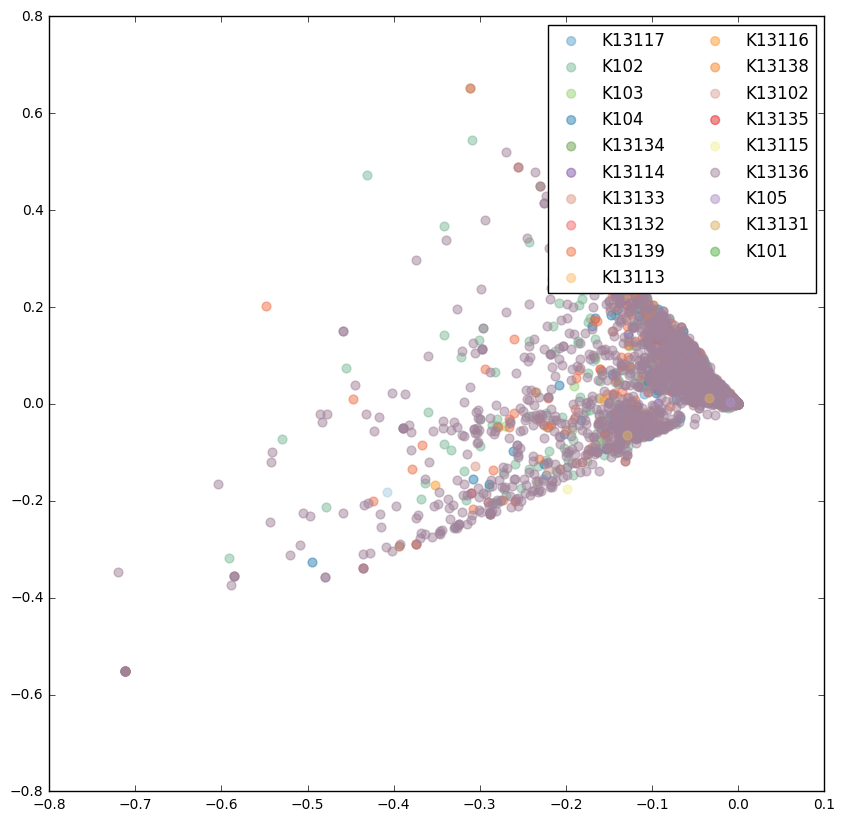

In [128]:
from collections import defaultdict
import pprint
import matplotlib.pyplot as plt

plot_axes(x=0, y=1)

x topic:
[('web', 0.55313702842406498), ('application', 0.34940973739092906), ('management', 0.31994020001264201), ('the', -0.2767098041289382), ('of', -0.25629118099967069), ('in', -0.18279018672572808), ('project', 0.17916020284906187), ('implementation', -0.16655122762269708), ('and', -0.13382213298057119), ('interface', 0.12654512238790699)]

y topic:
[('information', -0.55950617580396478), ('system', -0.54517775638470978), ('application', 0.24001265558600549), ('web', 0.18076528400280459), ('management', -0.15649499215966589), ('of', 0.15037970872540482), ('in', 0.13438733997438534), ('the', 0.12592093991975667), ('interface', 0.10387739674458007), ('data', 0.10233407370259412)]
next


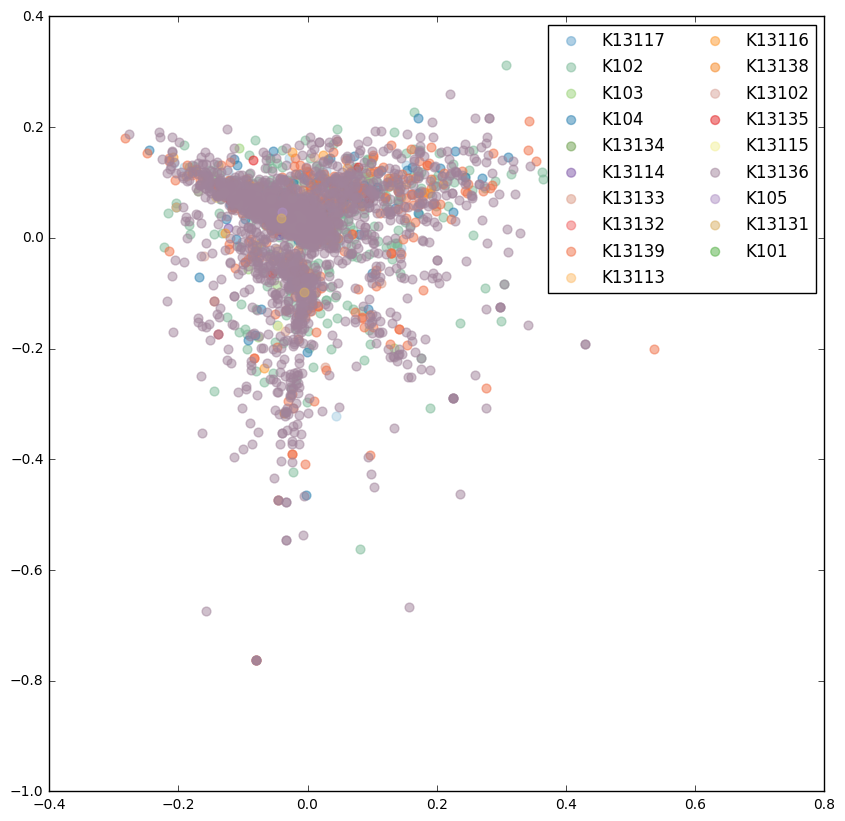

In [107]:
plot_axes(x=2, y=1)

x topic:
[('system', 0.37795221162317483), ('of', 0.30667720285333777), ('for', 0.29763124208033204), ('information', 0.27165121072447818), ('the', 0.24802550328530684), ('web', 0.2264657954273098), ('application', 0.19906685464793458), ('and', 0.19544917795603522), ('management', 0.19240727044420558), ('a', 0.16198243771977355)]

y topic:
[('management', 0.62193169715033714), ('project', 0.39455324616896054), ('web', -0.36925198631224104), ('information', -0.29356566129776823), ('software', 0.25541897164441407), ('content', 0.12588830821791666), ('interface', -0.12064891405670199), ('tool', 0.10354192870086973), ('service', -0.1003677023787168), ('network', 0.099935546864838451)]
next


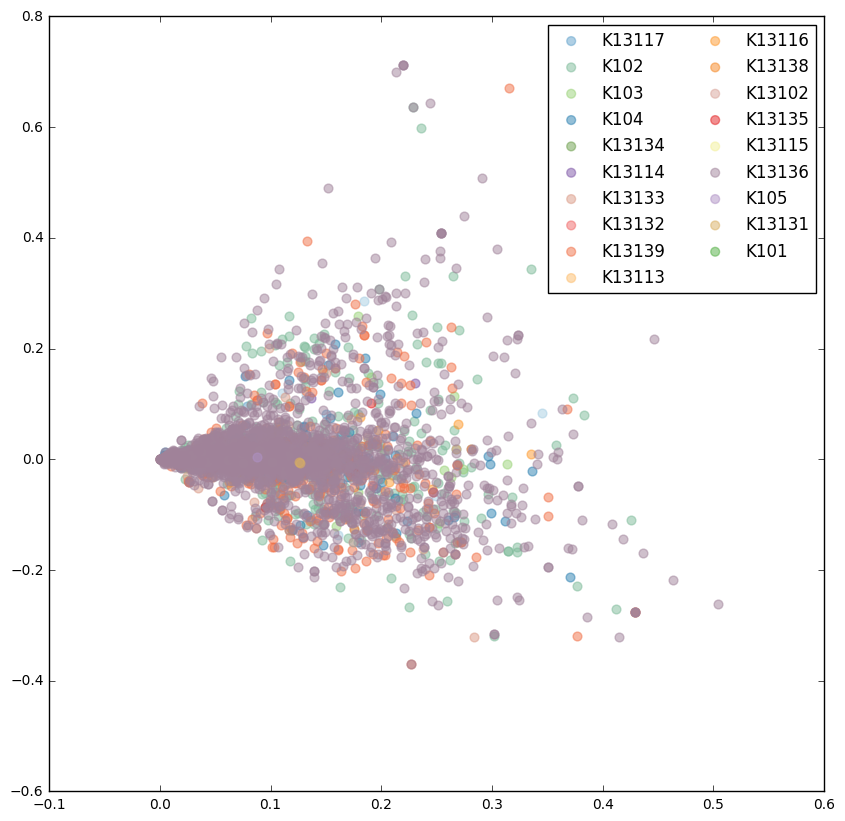

In [108]:
plot_axes(x=0, y=3)